Para este análisis se usó un conjunto de datos en el que se detallan los obsequios a funcionarixs públicxs registradxs en el ámbito de la Oficina Anticorrupción.
<a href="https://datos.gob.ar/dataset/justicia-registro-obsequios-funcionarios-publicos" target="_blank">Fuente de datos</a><br/><br/>
**Abarca el rango de 10/02/2017 a 08/10/2020.**

La Ley 25.188 de Ética en el Ejercicio de la Función Pública prohíbe a los funcionarios recibir obsequios o donaciones, con motivo o en ocasión del desempeño de sus funciones. <br/><br/>

Como excepción, pueden recibir aquellos obsequios que sean entregados por razones de cortesía o costumbre diplomática, pero sólo bajo las circunstancias establecidas en la referida ley y en el Decreto 1179/16 (Régimen de Obsequios a Funcionarios Públicos).<br/><br/>

Por su parte, todos los obsequios –admitidos por la ley 25.188- deben ser registrados y –cuando superan cierto valor (más de 4 módulos) o poseen significación institucional-, deben ser incorporados al patrimonio del Estado. <br/><br/>

Según el <a target="_blank" href="https://desafiospublicos.argentina.gob.ar/normativa/nacional/decreto-1030-2016-265506/texto">Decreto 1030/2016</a>, el valor del módulo (M) será de PESOS UN MIL ($ 1.000).


In [44]:
#importamos las librerías que vamos a necesitar
import io
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import os
import numpy as np
import fuzzywuzzy
import string
import requests

from fuzzywuzzy import process
from os import path
from spacy.lang.es import Spanish
from spacy.lang.es.stop_words import STOP_WORDS
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

In [45]:
# guardamos la ubicación para luego guardar imágenes que vamos a generar
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

data = pd.read_csv("./data/registro-obsequios-funcionarios-publicos-20201009.csv")
print(f'Cantidad de registros cargados: {len(data)}')

Cantidad de registros cargados: 3928


In [46]:
# limpieza y unificación de features
data["funcionario_nombre"] = data["funcionario_nombre_completo"].apply(str.title) + " " + data["funcionario_apellido_completo"].apply(str.title)
data["obsequio_descripcion"] = data["obsequio_descripcion"].str.lower()

In [47]:
def replace_matches_in_column(df, column, string_to_match, min_ratio=90):
    strings = df[column].unique()
    
    # obtener el top 10 de similitudes más cercanas al string que estamos analizando
    matches = fuzzywuzzy.process.extract(string_to_match, strings, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # filtramos y nos quedamos sólo con las coincidencias con un ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    rows_with_matches = df[column].isin(close_matches)
    df.loc[rows_with_matches, column] = string_to_match

Al ver los nombres de funcionarixs, podemos notar que hay "repetidxs", ya sea por diferente cantidad de espacios entre palabras, por uso (o no) de tildes y otras razones. <br/>
Para verificar ésto (y arreglarlo) vamos a usar <a href="https://github.com/seatgeek/fuzzywuzzy" target="_blank">fuzzywuzzy</a>. <br/><br/>
En la celda siguiente veremos cuántos nombres parecidos a "Matías Daniel Lammens Núñez".<br/>

El número que aparece junto a la variante del nombre es el porcentaje de similitud (se pueden elegir diferentes métodos para analizar cuan similares son, en este caso elegimos `token_sort_ratio`).

In [48]:
df = data["funcionario_nombre"].unique()
df.sort()

matches = fuzzywuzzy.process.extract("Matías Daniel Lammens Núñez", df, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
print(matches)

[('Matías Daniel Lammens Núñez', 100), ('Matias Daniel Lammens Núñez', 98), ('Matías Daniel Lammens Nuñez', 98), ('Matías Lammens', 70), ('Matias Lammens', 68), ('Diana Maria Guillen', 56), ('Daniel Meilan', 54), ('Ramón María Lanús', 53), ('Maria Gabriela Real', 51), ('Marta Gabriela Michetti', 51)]


In [49]:
print('Cantidad de nombres de funcionarixs')
print(f'Antes de la limpieza: {len(df)}')

names_to_replace = [{"name": "Alberto Angel Fernandez", "min_ratio":80}, {"name": "Germán Carlos Garavano", "min_ratio":84}, {"name": "Matías Daniel Lammens Núñez", "min_ratio":67}, {"name":"Patricia Bullrich" , "min_ratio":75}]

for item in names_to_replace:
    replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match=item.get("name"), min_ratio=item.get("min_ratio"))

names_to_replace = ["Agustin Dellagiovanna", "Alberto Jorge Triaca", "Carlos Vicente Ruá", "Cristina E. Fernández O Néstor C. irchner", "Cristián Roberto Dellepiane Rawson", "Damián Eduardo Arabia", "Dante Sica", "Fernando Félix Grasso", "Gustavo José Santos", "José Lino Salvador Barañao", "Marcelo Gabriel Suárez Salvia", "Maria Inés Baque", "Marta Gabriela Michetti", "María Eugenia Bielsa", "María Lara González Carvajal", "Ramón Lanús", "Ramón María Lanús", "Ricardo Agustín Campero", "Roberto Salvarezza", "Rogelio Frigerio", "Santiago Tomás Bellomo", "Mauricio Macri"]

for name in names_to_replace:
    replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match=name)

df = data["funcionario_nombre"].unique()
df.sort()
print(f'Después de la limpieza: {len(df)}')

Cantidad de nombres de funcionarixs
Antes de la limpieza: 366
Después de la limpieza: 326


In [50]:
#considerando que también hay varios roles con nombres similares..  necesitamos unificarlos
data["funcionario_funcion"] = data["funcionario_funcion"].str.lower()
data["funcionario_funcion"] = data["funcionario_funcion"].str.strip()

def cleanTxt(text):
 text = text.replace("registro de obsequios- señor presidente de la nación",'señor presidente de la nación')
 text = text.replace("hija de la señora de macri", "hija de la señora primera dama, srita valentina barbier")
 text = text.replace("hija del presidente de la nación de la nación, srita. antonia macri", "hija del presidente de la nación, srita. antonia macri")
 text = text.replace("vicepreseidencia",'vicepresidente')
 text = text.replace("presiente",'presidente')
 return text

data["funcionario_funcion"] = data.funcionario_funcion.apply(cleanTxt)

In [51]:
# Tomado prestado de José https://github.com/casanovajose/lo_regalito
def obsequiador_name(row):
  name = []
  data = []
  nombre = row["obsequiador_nombre_completo"]
  apellido = row["obsequiador_apellido_completo"]    
  razon_social = row["obsequiador_razon_social"]
  organismo = row["obsequiador_organismo"]
  descripcion = row["obsequiador_descripcion"]  
  if type(nombre) == str:
      name.append(nombre)
      
  if type(apellido) == str:
      name.append(apellido)
      
  name = " ".join(name)
  name = name.strip()  
  if type(razon_social) == str:
      data.append(razon_social)
      
  if type(organismo) == str:
      data.append(organismo)  
  if type(descripcion) == str:
      data.append(descripcion)  
  if len(name) > 0:
      data.insert(0, name)

  return " | ".join(data)

data["obsequiador_nombre"] = data.apply(obsequiador_name, axis=1)

In [52]:
# Chequeamos roles similares y determinamos el min_ratio que debería usar para reemplazar lo que quiero reemplazar
df = data["funcionario_funcion"].unique()
matches = fuzzywuzzy.process.extract("presidente", df, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
print(matches)

[('presidente', 100), ('presidente.', 100), ('vicepresidente', 83), ('presidente - aabe', 80), ('presidente aabe', 80), ('vicepresidenta', 75), ('presidente de nación', 69), ('presidente de la nación', 62), ('presidente de la  nación', 62), ('presidente de la naciòn', 62)]


In [53]:
df = data["funcionario_funcion"].unique()
df.sort()
print('Cantidad de roles de funcionarixs')
print(f'Antes de la limpieza: {len(df)}')

roles_to_replace = [{"role": "ministra de relaciones exteriores y culto", "min_ratio": 85}, {"role": "ministro de producción y trabajo", "min_ratio": 80}, {"role": "secretario general de la presidencia de la nación", "min_ratio": 80}, {"role": "señora primera dama", "min_ratio": 65}, {"role": "subsecretario", "min_ratio": 88}, {"role": "titular", "min_ratio": 70}, {"role": "ministra de seguridad", "min_ratio":78}, {"role": "ministro de educación y deportes de la nación", "min_ratio": 84}, {"role": "hija de la señora primera dama, srita valentina barbier", "min_ratio": 62}, {"role": "ministro de educación, cultura, ciencia y tecnología", "min_ratio": 85}, {"role": "ministro de agricultura, ganadería y pesca de la nación", "min_ratio": 85}, {"role": "secretario de coordinación de políticas públicas", "min_ratio": 79}, {"role": "jefa del dpto de priv, e inmun, acred. y guía diplo", "min_ratio": 82}, {"role": "presidencia de la nación", "min_ratio": 87}, {"role": "hija del presidente de la nación, srita. antonia macri", "min_ratio": 75}, {"role": "secretario de relaciones exteriores", "min_ratio": 97}, {"role": "presidente", "min_ratio": 100}]

for item in roles_to_replace:
    replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match=item.get("role"), min_ratio=item.get("min_ratio"))

roles_to_replace = ["jefe de gabinete de ministros", "directora nacional de ética pública", "ministro de turismo y deportes", "ministro de turismo", "secretaría de ética pública transparencia y lucha contra la corrupción", "secretaria de relaciones políticas y parlamentarias", "secretario de economía social", "secretario de gobierno de energia", "secretario de seguridad interior", "subsecretario de política exterior", "coordinador de relaciones institucionales con dependencia directa del ministerio de produccion", "coordinador/a general", "ministra de seguridad de la nación", "jefa de gabinete", "presidente - aabe", "secretario de agricultura, ganadería y pesca", "supervisor de fiscalización", "vicepresidente de la nación"]

for role in roles_to_replace:
    replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match=role)

df = data["funcionario_funcion"].unique()
df.sort()
print(f'Después de la limpieza: {len(df)}')

Cantidad de roles de funcionarixs
Antes de la limpieza: 294


Después de la limpieza: 214


Para que las comparaciones entre cantidad de obsequios recibidos sean más objetivas vamos a calcular: <br/>`cantidad de regalos / cantidad de días en el cargo` <br/><br/>
Siendo que lo hacemos sólo para lxs primerxs 10 funcionarixs, calculamos "a mano" los días en el cargo (léase calculando el solapamiento entre período en el cargo y rango de fechas de los datos que usamos).

In [54]:
#Rango de fechas de los datos usados: 10/02/2017 a 08/10/2020
dias_en_cargo_mm = 1033 #Mauricio Macri
dias_en_cargo_af = 303 #Alberto Angel Fernandez    
dias_en_cargo_gg = 1033 #Germán Carlos Garavano     
dias_en_cargo_jf = 911 #Jorge Faurie               
dias_en_cargo_rf = 1033 #Rogelio Frigerio           
dias_en_cargo_sm = 122 #Susana Malcorra
dias_en_cargo_ja = 1033 #Juliana Awada
dias_en_cargo_mp = 1033 #Marcos Peña                
dias_en_cargo_at = 662 #Alberto Jorge Triaca - denuncia
dias_en_cargo_ml = 303 #Matías Daniel Lammens Núñez

dias_en_cargo = pd.Series([dias_en_cargo_mm, dias_en_cargo_af, dias_en_cargo_gg, dias_en_cargo_jf, dias_en_cargo_rf, dias_en_cargo_sm, dias_en_cargo_ja, dias_en_cargo_mp, dias_en_cargo_at, dias_en_cargo_ml])

/tmp/ipykernel_36663/4139346191.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


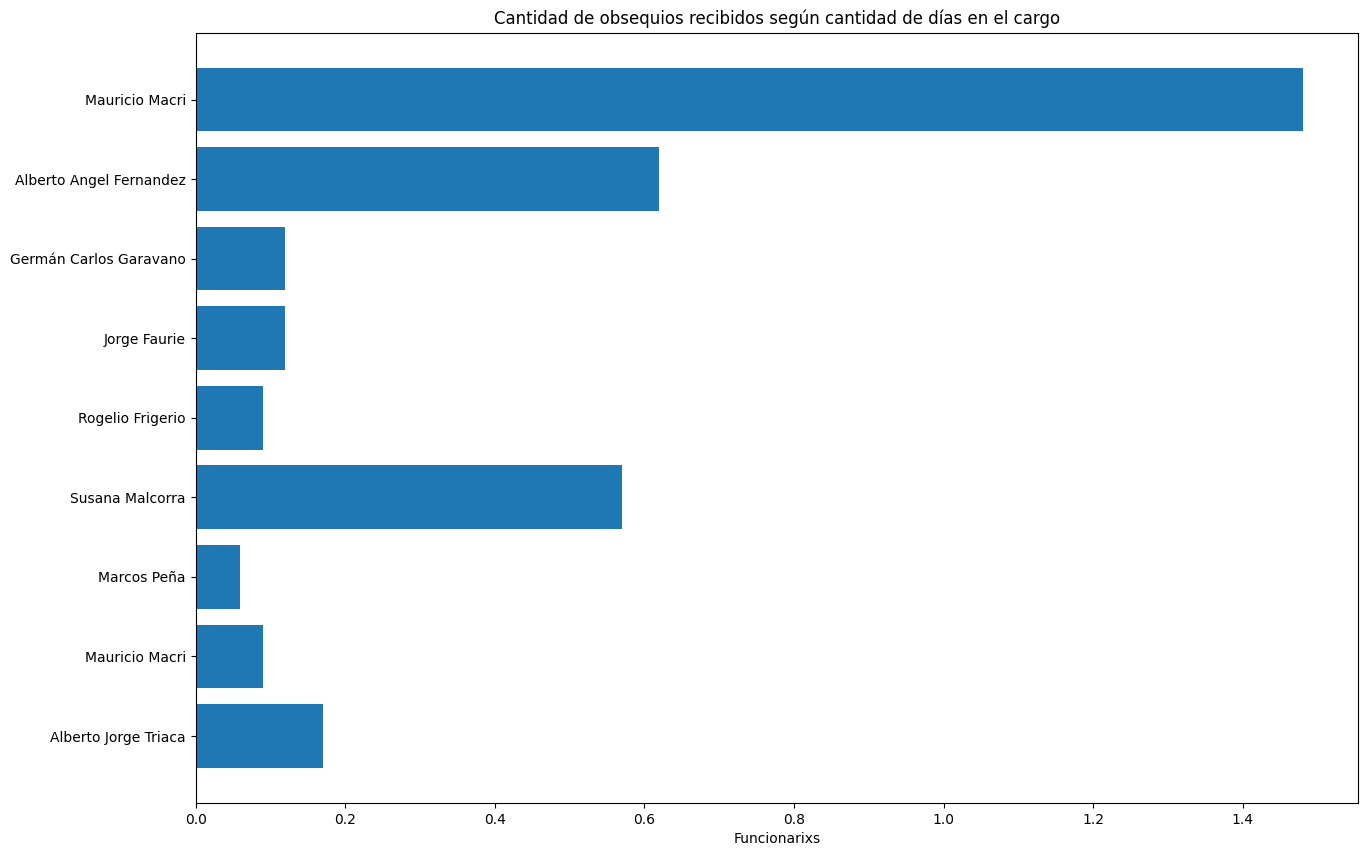

In [55]:
# Como inicialmente convertimos los roles a minúsculas para "limpiarlos y unificarlos".. ahora los volvemos a convertir a CamelCase
CANT_FUNCIONARIXS = 10
data["funcionario_funcion"] = data["funcionario_funcion"].str.title()

top_regalos = data
top_regalos['cantidad_de_regalos'] = 1
top_regalos = data.groupby(['funcionario_nombre', 'funcionario_funcion'], as_index=False).sum().sort_values('cantidad_de_regalos', ascending=False).reset_index().head(CANT_FUNCIONARIXS)
top_regalos = top_regalos[["funcionario_nombre", "cantidad_de_regalos"]]
top_regalos["cantidad_de_regalos"] = top_regalos["cantidad_de_regalos"].div(dias_en_cargo).round(2)


labels = list(top_regalos.funcionario_nombre)
values = list(top_regalos.cantidad_de_regalos)
fig, ax = plt.subplots(figsize=(15, 10))
ax.barh(labels, values, align="center")
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel("Funcionarixs")
ax.set_title("Cantidad de obsequios recibidos según cantidad de días en el cargo")
plt.show()

Podemos ver que Mauricio Macri recibió 1.4 regalos por día en su cargo, mientras que el resto de lxs funcionarixs recibieron muchos menos.

Al ver estos números, nos surgió la intriga de quiénes eran las personas que ocupaban cargos de ministrxs sin indicar el área en que trabajan y que recibieron tantos regalos como para estar en el top 10.

Según Wikipedia:
* **Germán Garavano** se desempeñó como  ministro de Justicia y Derechos Humanos de la República Argentina desde el 10 de diciembre de 2015 hasta el 9 de diciembre de 2019.<br/><img width="200px" src="https://upload.wikimedia.org/wikipedia/commons/f/f2/German-garavano.jpg"/>

* **Rogelio Frigerio** ocupó el cargo de Ministro del Interior, Obras Públicas y Vivienda del gobierno de Mauricio Macri desde el 10 de diciembre de 2015 hasta el 10 de diciembre de 2019.<br/><img width="200px" src="https://upload.wikimedia.org/wikipedia/commons/e/e7/Rogelio_Frigerio_2015.jpg"/>

* **Alberto Jorge Triaca** fue nombrado ministro de Trabajo en 2015 por Mauricio Macri,​ cargo que ocupó hasta 2018 cuando fue degradado a secretario de Trabajo del ministerio de Producción tras una reestructuración del gabinete.<br/><img width="200px" src="https://upload.wikimedia.org/wikipedia/commons/d/d6/Jorge_Triaca_hijo_%28cropped%29.jpg"/>

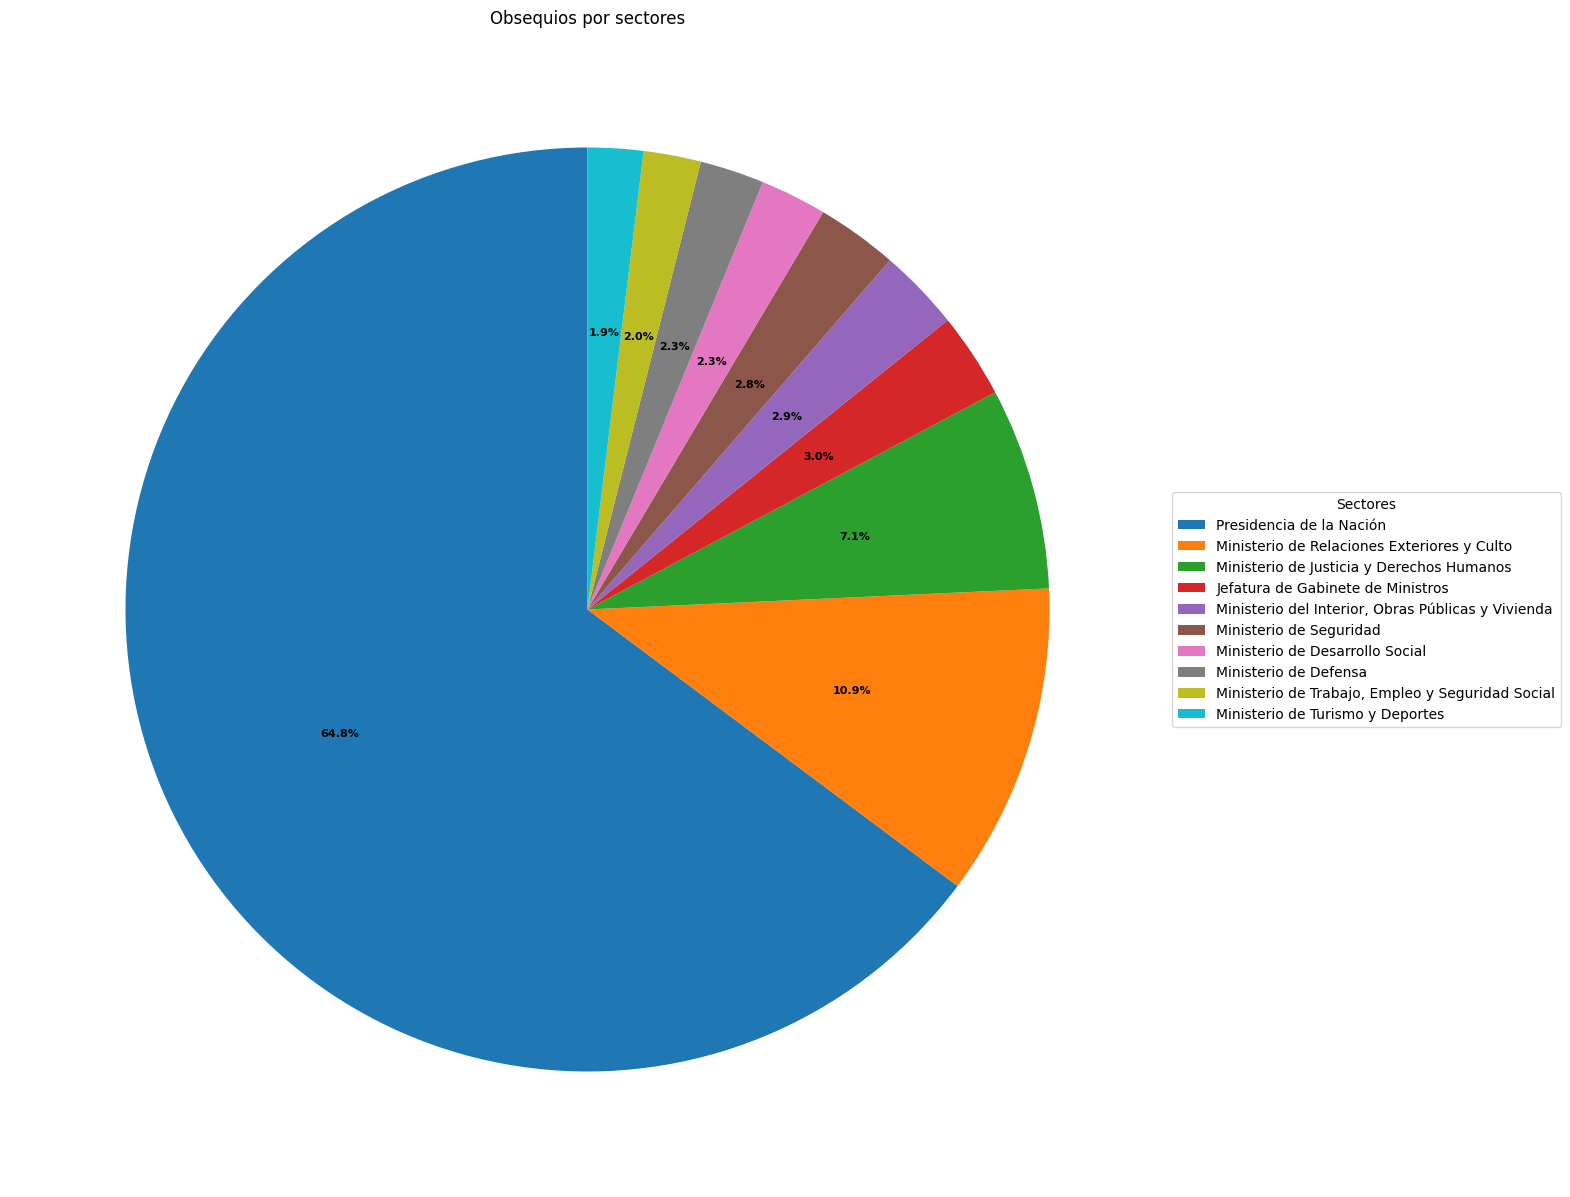

In [56]:
gifts_received_by_minister = data["funcionario_jurisdiccion"].value_counts().head(10)
labels = gifts_received_by_minister.keys()
values = gifts_received_by_minister.values

fig, ax = plt.subplots(figsize=(20, 15), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(values, startangle=90, autopct='%1.1f%%')
ax.legend(wedges, labels, title="Sectores", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Obsequios por sectores")
plt.show()

In [57]:
def make_wordcloud(data, filename=None):
    wc = WordCloud(background_color="white", width=1000, height=500).generate_from_frequencies(data)
    plt.figure(figsize=(15,8))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    if filename:
        wc.to_file(path.join(d, filename+".png"))

Lxs 20 funcionarixs que más regalos recibieron


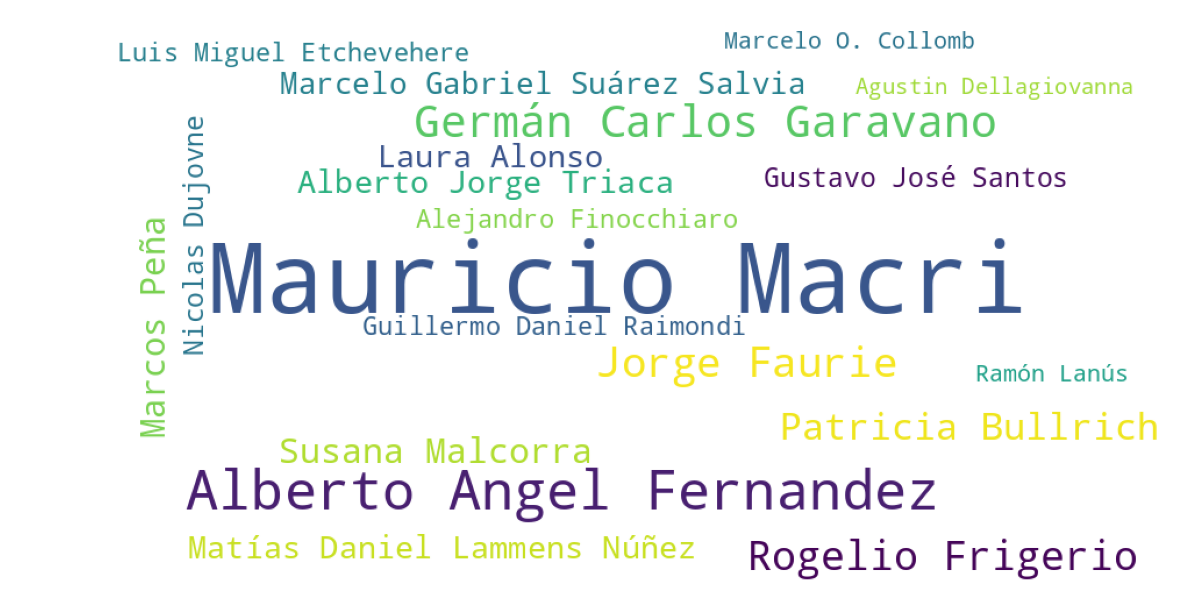

In [58]:
print("Lxs 20 funcionarixs que más regalos recibieron")
gift_by_func_counter = Counter(data.funcionario_nombre)
make_wordcloud(dict(gift_by_func_counter.most_common(20)))
#use it to save wordcloud as a file
#make_wordcloud(dict(gift_by_func_counter.most_common(20)), "roles_more_received_gifts_wordcloud") 

<img width="500px" src="https://info135.com.ar/wp-content/uploads/2017/07/macri-festeja.jpg"/>

## (Anti) Conclusiones

In [59]:
def show_image_from_url(url, size=600):
    response = requests.get(url, stream=True)
    image = Image.open(response.raw)
    my_dpi = 100
    fig = plt.figure(figsize=(size/my_dpi, size/my_dpi), dpi=my_dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(image)
    plt.show()

¿Quiénes le hicieron obsequios a Mauricio Macri y a Alberto Fernandez?


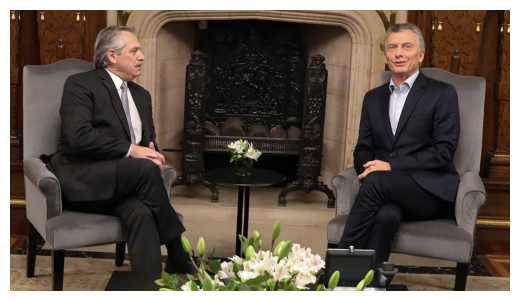

['Alejandro Dominguez',
 'Jorge Oscar Gornatti',
 'Mario Abdo',
 'Moon Jae-in',
 'Norberto Rodriguez',
 'Norelia Dabart',
 'Pedro Andrés Sulich',
 'Sindicato "La Fraternidad"']

In [60]:
print("¿Quiénes le hicieron obsequios a Mauricio Macri y a Alberto Fernandez?")
gifts_to_mmacri = data.loc[data["funcionario_nombre"] == "Mauricio Macri", "obsequiador_nombre"].unique()
gifts_to_afernandez = data.loc[data["funcionario_nombre"] == "Alberto Angel Fernandez", "obsequiador_nombre"].unique()
gifts_to_presidents = np.intersect1d(gifts_to_mmacri, gifts_to_afernandez)
gifts_to_presidents = gifts_to_presidents[np.where((gifts_to_presidents != "Ciudadana Ciudadana") & (gifts_to_presidents != "Ciudadano Ciudadano"))]

url = 'http://www.telam.com.ar/advf/imagenes/2019/10/5db759f9b690a_1004x565.jpg'
show_image_from_url(url, 500)

list(gifts_to_presidents)

In [61]:
print("Obsequios hechos por personas que regalaron tanto a Mauricio Macri como a Alberto Fernandez")
print("")

for obsequiador in gifts_to_presidents:
    print(f"Obsequios hechos por {obsequiador}")
    gifts_from_x = data.loc[data["obsequiador_nombre"] == obsequiador, ["funcionario_nombre", "obsequio_descripcion"]]
    df = pd.DataFrame(gifts_from_x.values.tolist(), columns=gifts_from_x.columns.tolist())
    display(df)
    print("")

Obsequios hechos por personas que regalaron tanto a Mauricio Macri como a Alberto Fernandez

Obsequios hechos por Alejandro Dominguez


,funcionario_nombre,obsequio_descripcion
0,Mauricio Macri,un (1) poncho celeste
1,Mauricio Macri,"dos (2) remeras de fútbol de ""club atlético ta..."
2,Mauricio Macri,un (1) trofeo + medalla de conmebol
3,Alberto Angel Fernandez,una (1) camiseta de la selección argentina
4,Alberto Angel Fernandez,una (1) réplica de la copa américa/una (1) rép...



Obsequios hechos por Jorge Oscar Gornatti


,funcionario_nombre,obsequio_descripcion
0,Mauricio Macri,"un (1) libro ""un hombre, una historia, un gremio"""
1,Mauricio Macri,"una (1) revista: "" lugares turísticos de la ar..."
2,Mauricio Macri,dos (2) revistas de el trabajador maderero
3,Alberto Angel Fernandez,"una (1) revista: ""suplemento de turismo social..."



Obsequios hechos por Mario Abdo


,funcionario_nombre,obsequio_descripcion
0,Mauricio Macri,"una (1) botella de ron ""fortin"""
1,Mauricio Macri,un (1) sombrero de mimbre
2,Alberto Angel Fernandez,una (1) camisa de lino blanca



Obsequios hechos por Moon Jae-in


,funcionario_nombre,obsequio_descripcion
0,Mauricio Macri,una (1) caja con cintas y adhesivos del palace...
1,Alberto Angel Fernandez,un (1) adorno de pie tradicional coreano



Obsequios hechos por Norberto Rodriguez


,funcionario_nombre,obsequio_descripcion
0,Mauricio Macri,"un (1) libro: ""valores, pensamiento crítico y ..."
1,Alberto Angel Fernandez,"un (1) libro: ""valores, pensamiento crítico y ..."



Obsequios hechos por Norelia Dabart


,funcionario_nombre,obsequio_descripcion
0,Mauricio Macri,"un (1) libro: ""trauma"""
1,Alberto Angel Fernandez,"dos (2) cds: ""plenitud""/ ""semillas de mi"""



Obsequios hechos por Pedro Andrés Sulich


,funcionario_nombre,obsequio_descripcion
0,Mauricio Macri,"un (1) libro: ""pedro, caminante de la fe"""
1,Alberto Angel Fernandez,"dos (2) libros: ""pedro, caminante de la fe"""



Obsequios hechos por Sindicato "La Fraternidad"


,funcionario_nombre,obsequio_descripcion
0,Mauricio Macri,una (1) escultura conmemorativa por el 130º an...
1,Alberto Angel Fernandez,"una (1) gorra con el logo del sindicato ""la fr..."


Pero... quiénes son estas personas que le regalaron a los últimos 2 presidentes?

Según Wikipedia o Google:
* **Alejandro Guillermo Domínguez Wilson-Smith** es un empresario y dirigente deportivo paraguayo que en 2016 fue elegido presidente de la Confederación Sudamericana de Fútbol, cargo que actualmente ejerce tras su reelección en 2018 para el periodo 2019-2022. También es el presidente de la Commisión de Finanzas de la FIFA.

* **Jorge Oscar Gornatti** Vicepresidente de la Obra Social del Personal de la Industria Maderera, Secretario General de la Unión de Sindicatos de la Industria Maderera de la República Argentina (USIMRA).

* **Mario Abdo** es un político y empresario paraguayo, actual presidente de Paraguay desde el 15 de agosto de 2018.​ Miembro del Partido Colorado, antes de ser presidente fue senador en el Congreso de Paraguay, donde ejerció también como presidente del Senado entre 2015 y 2016.​ 

* **Moon Jae-in** es un político surcoreano, actual líder del Partido Democrático de Corea y presidente de Corea del Sur desde el 10 de mayo de 2017, tras resultar victorioso en las elecciones presidenciales de ese año. Moon fue líder de la oposición en la 19.ª Asamblea Nacional antes de ser presidente desde 2015.

* **Norberto Rodriguez** es secretario general de la Asociación Cristiana de Jóvenes/YMCA.

* **Norelia Dabart** es cantante originaria de Córdoba.

* **Pedro Andrés Sulich** regaló el libro "Pedro, Caminante de la fe" a ambos presidentes.

* **Sindicato "La Fraternidad"** es un sindicato argentino que agrupa a los maquinistas (conductores) de locomotoras y trenes.


De las personas antes mencionadas, la que llamó mi atención es el presidente de Corea del Sur, Moon Jae-in. <br/>
<img width="200px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c9/Moon_Jae-in_%282017-10-01%29_cropped.jpg/220px-Moon_Jae-in_%282017-10-01%29_cropped.jpg"/><br/>
Googleando un poco encontré esta <a href="https://www.infobae.com/politica/2020/07/03/alberto-fernandez-dialogo-con-su-par-de-corea-del-sur-uno-de-los-paises-que-genera-discusiones-en-el-mercosur/" target="_blank">nota</a> en la que dice: _ "... la Argentina ya había puesto sus reparos a avanzar en este acuerdo con Corea del Sur al igual que con Singapour por las eventuales desventajas comerciales que implicaría esto para el bloque regional."_ <br/>

_Además, las autoridades sanitarias de los gobiernos nacionales de Corea y Argentina mantienen una relación de cooperación frente a la pandemia y proyectaron planes de cooperación en materia de salud._ <br/><br/>

¿Tendrán algo que ver tantos regalos con las ganas de que se concrete el acuerdo de libre comercio entre Argentina y Corea del Sur?

Bolsonaro quiere a Mauricio Macri pero no a Alberto Fernandez


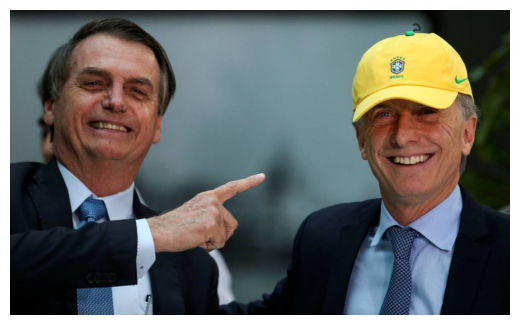

,funcionario_nombre,obsequio_descripcion
2762,Mauricio Macri,un (1) cuadro representativo de un cocard indi...
3138,Mauricio Macri,una (1) gorra de fútbol de brasil/un (1) vaso ...
3140,Mauricio Macri,una (1) pintura de flor
3361,Mauricio Macri,un (1) juego de vasijas de melamina


In [62]:
print("Bolsonaro quiere a Mauricio Macri pero no a Alberto Fernandez")
gifts_from_bolsonaro = data.loc[data["obsequiador_nombre"] == "Jair Messias Bolsonaro", ["funcionario_nombre", "obsequio_descripcion"]]
show_image_from_url("https://ep01.epimg.net/internacional/imagenes/2019/06/10/argentina/1560202410_386123_1560202503_noticia_normal.jpg", 500)
gifts_from_bolsonaro

In [63]:
print("Los regalos que le confiscaron a a Cristina Kirchner (Causa 9608/18 del juzgado federal, criminal y correccional 11)")

confiscated_gifts = data.loc[data["obsequio_descripcion"].str.contains("causa 9608/18"), ["obsequiador_nombre", "obsequio_descripcion", "obsequio_valor_estimado"]]

def cleanTxt(text):
 text = text.replace("inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de dicha comunicación",'')
 text = text.replace("inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de la comunicación", "")
 text = text.replace(" -- ",'').replace("-",',').replace(" , ",', ')
 text = text.replace("\"",'')
 text = re.sub(r'\(([0-9]+)\)', '', text)
 text = re.sub(' +', ' ', text)
 text = text.strip()
 return text

# Limpiamos las descripciones de regalos
confiscated_gifts["obsequio_descripcion"] = confiscated_gifts.obsequio_descripcion.apply(cleanTxt)

display(confiscated_gifts)

Los regalos que le confiscaron a a Cristina Kirchner (Causa 9608/18 del juzgado federal, criminal y correccional 11)


,obsequiador_nombre,obsequio_descripcion,obsequio_valor_estimado
2085,Se desconoce,lapicera cross de metal blanco,Superior a 4 módulos o imposibilidad de determ...
2086,Se desconoce,lapicera cartier color blanco,Superior a 4 módulos o imposibilidad de determ...
2087,Se desconoce,"lapicera y señalador con escudo nacional, ambo...",Superior a 4 módulos o imposibilidad de determ...
2088,Se desconoce,6 lapiceras montblanc y certif etoile de montb...,Superior a 4 módulos o imposibilidad de determ...
2089,Se desconoce,"rosa metálica,",Superior a 4 módulos o imposibilidad de determ...
2090,Se desconoce,escudo metálico de la provincia de entre ríos,Superior a 4 módulos o imposibilidad de determ...
2091,Sultán Saman Bin Al Abdullah,daga árabe en metal amarillo en su vaina con c...,Superior a 4 módulos o imposibilidad de determ...
2092,Luis Miguel .,"rosa metálica con una chapa que reza cristina,...",Superior a 4 módulos o imposibilidad de determ...
2093,Se desconoce,escultura metálica en forma de rosa,Superior a 4 módulos o imposibilidad de determ...
2094,Se desconoce,chapa metalica que reza sagai y rosa metálica,Superior a 4 módulos o imposibilidad de determ...


<img width="200px" src="https://aws.revistavanityfair.es/prod/designs/v1/assets/655x803/187136.jpg"/><br/>

Si.. vieron bien, Luis Miguel le regaló una "rosa metálica con una chapa que reza: Cristina, con aprecio de Luis Miguel".<br/><br/>
Convengamos que dado que los obsequios tienen un valor mayor a 4 módulos o no se puede determinar su valor, se deberían haber incorporado al patrimonio del Estado.<br/><br/>
**Y encima los regalos los tiene que compartir?**<br/>
Así aparece la descripción de quienes son destino de los regalos (?)

In [64]:
data[data.funcionario_nombre.str.contains("Cristina E. Fernández")].funcionario_nombre.unique()[0]

'Cristina E. Fernández O Néstor C. irchner'

In [65]:
print("¿Quiénes recibieron alimentos que valen más de $4.000?")
alimentos = data.loc[(data.obsequio_tipo == "Alimentos") & (data.obsequio_valor_estimado=="Superior a 4 módulos o imposibilidad de determinar su valor."), ["obsequiador_nombre", "funcionario_nombre", "funcionario_funcion", "obsequio_descripcion"]]
alimentos

¿Quiénes recibieron alimentos que valen más de $4.000?


,obsequiador_nombre,funcionario_nombre,funcionario_funcion,obsequio_descripcion
1284,Guillermo Calcagno,Ignacio Pérez Riba,Jefa De Gabinete,botellas de champagne don perignon (2)
1737,Ministro del Comercio Exterior y la Inversión ...,Marcos Peña,Jefe De Gabinete De Ministros,un (1) ron santiago de cuba extra añejo 25 año...
3676,"Ministerio de Agricultura, Ganadería y Abastec...",Luis Eugenio Basterra,"Ministro De Agricultura, Ganadería Y Pesca De ...","bebida cachaca, ""weber haus"", bebida alcohólic..."
3681,"Embajada de la India, Argentina Uruguay y Para...",Luis Eugenio Basterra,"Ministro De Agricultura, Ganadería Y Pesca De ...",2 latas de té de la india
3683,Administración General de la Aduana en China,Luis Eugenio Basterra,"Ministro De Agricultura, Ganadería Y Pesca De ...",4 cajas de té
3703,Embajada de la República Popular China en Arge...,Diana Maria Guillen,Titular De La Unidad Gabinete De Asesores,4 cajas de té


In [66]:
print("¿Quién se ha tomado todo el vino?")
vinos = data.loc[(data.obsequio_tipo == "Alimentos") & (data.obsequio_descripcion.str.contains("vino")), ["obsequiador_nombre", "funcionario_nombre", "funcionario_funcion", "obsequio_descripcion"]]

suma_vinos = vinos.copy()
suma_vinos['obsequios_que_incluyen_vinos'] = 1
suma_vinos = suma_vinos.groupby(["funcionario_nombre"]).sum().sort_values("obsequios_que_incluyen_vinos", ascending=False)
display(suma_vinos.head(10))

¿Quién se ha tomado todo el vino?


,obsequiador_nombre,funcionario_funcion,obsequio_descripcion,obsequios_que_incluyen_vinos
funcionario_nombre,,,,
Mauricio Macri,Audiencias con empresariosParticipante del Loc...,Presidencia De La NaciónPresidencia De La Naci...,una (1) botella de vino en un estuche con form...,30
Marcos Peña,Paola BíscaroMartín GrandeMartín GrandeRodolfo...,Jefe De Gabinete De MinistrosJefe De Gabinete ...,vino - encuentro cabernet sauvignon 2014 -le c...,18
Alberto Jorge Triaca,CONFEDERACION ARG. DE TRANSPORTE AUTOMOTOR DE ...,MinistroMinistroMinistroMinistroMinistroMinist...,caja de vinoscaja de vinosbotella de vinovino ...,17
Rogelio Frigerio,MINISTERIO DE HACIENDA Y FINANZAS DE SAN JUANJ...,MinistroMinistroMinistroMinistroMinistroMinist...,"2 cajas de vinovino espumante, whisky y alimen...",12
Santiago Bausili,GhellaSantander RíoGobierno de la Pcia. de Neu...,Secretario De FinanzasSecretario De FinanzasSe...,2 vinos luigi bosca malbec 20153 vinos cadus t...,10
Alejandro Finocchiaro,Universidad Abierta InteramericanaUniversidad ...,Ministro De Educación Y Deportes De La NaciónM...,vinovinos1 vinocaja con 2 vinoscaja de vinos1 ...,9
Marcelo Gabriel Suárez Salvia,Azulado S.A.Embajada de la República Argelina ...,Director Nacional De CeremonialDirector Nacion...,botella de vino malbec y botella vino espumoso...,7
Ramón Lanús,Munic. de NeuquénMunic. de TunuyánJosé Manuel ...,Presidente - AabePresidentePresidentePresident...,6 vinos sauruscaja de 6 vinos salenteinvino ru...,7
Matías García Oliver,Botella de Vino Escorihuela Gascón MalbecVino ...,SubsecretarioSubsecretarioSubsecretarioAsesorA...,botella de vino escorihuela gascón malbec-vino...,6


In [67]:
print("¿Quiénes tiene más riesgo de sufrir un ataque al hígado?")
ataque_higado = data.copy()
cond_alimentos = data.obsequio_tipo == "Alimentos"
ataque_higado["vinos"] = cond_alimentos & (data.obsequio_descripcion.str.contains("vino"))
ataque_higado["chocolates"] = cond_alimentos & (data.obsequio_descripcion.str.contains("chocolate"))
ataque_higado["salames"] = cond_alimentos & (data.obsequio_descripcion.str.contains("salam"))
ataque_higado["alfajores"] = cond_alimentos & (data.obsequio_descripcion.str.contains("alfajor"))

ataque_higado= ataque_higado[["funcionario_nombre", "vinos", "chocolates", "salames", "alfajores"]]
ataque_higado.groupby(["funcionario_nombre"]).sum().sort_values(["vinos", "chocolates", "salames", "alfajores"], ascending=False).head(10)

¿Quiénes tiene más riesgo de sufrir un ataque al hígado?


,vinos,chocolates,salames,alfajores
funcionario_nombre,,,,
Mauricio Macri,30,24,13,26
Marcos Peña,18,2,0,2
Alberto Jorge Triaca,17,0,0,0
Rogelio Frigerio,12,1,0,0
Santiago Bausili,10,0,0,0
Alejandro Finocchiaro,9,0,0,0
Ramón Lanús,7,0,0,1
Marcelo Gabriel Suárez Salvia,7,0,0,0
Ignacio Pérez Riba,6,0,0,0


In [68]:
# Creamos una función para limpiar las descripciones de regalos
def cleanTxt(text):
 text = text.replace("inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de dicha comunicación",'')
 text = text.replace(" -- ",'').replace("-",',').replace(" , ",', ')
 text = text.replace("\"",'')
 text = re.sub(r'\(([0-9]+)\)', '', text)
 text = re.sub(' +', ' ', text)
 text = text.strip()
 return text

expensive_gifts = data[data.obsequio_valor_estimado=="Superior a 4 módulos o imposibilidad de determinar su valor."]
expensive_gifts.loc[:,"obsequio_descripcion"] = expensive_gifts.obsequio_descripcion.apply(cleanTxt)

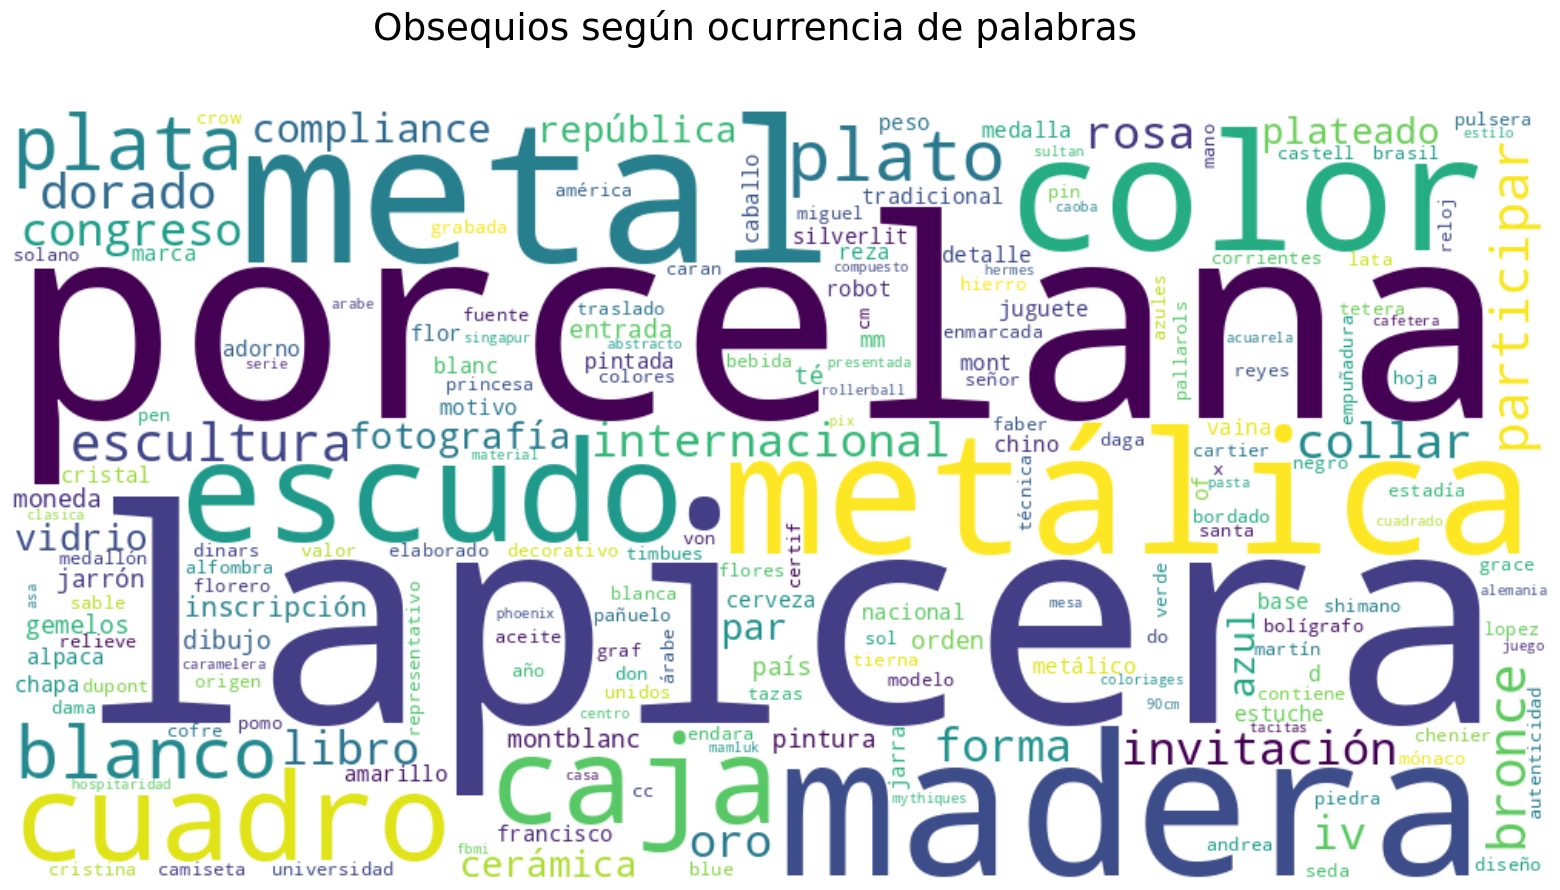

In [69]:
# word cloud visualization
allWords = ' '.join(expensive_gifts.obsequio_descripcion)
wordCloud = WordCloud(background_color="white", width=1000, height=500,random_state=21, stopwords=STOP_WORDS, collocations=False)
wordCloud.generate(allWords)

#show
fig = plt.figure(figsize=(20, 10))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
fig.suptitle("Obsequios según ocurrencia de palabras", fontsize=27)
plt.show()

#store to file
#wordCloud.to_file(path.join(d, "christmas_for_politicians.png"))

## "Problemas" y sugerencias de mejora

- Como `funcionario_nombre` aparece “Jefatura Jefatura”, “Prueba Prueba”, “X X”. 
    - <ins>Sugerencia</ins>: para facilitar la limpieza y el procesamiento de la información, sería bueno seleccionar funcionarixs de una base de datos unificada para que la información sea consistente a lo largo de los sistemas que requieren usar dicha información. 

- Está mal etiquetada la función y el nombre de quienes reciben regalos en muchos casos, por ejemplo: "Mauricio Macri aparece como _Señora primera dama_ y como _Hija Del Señor Presidente, Srita Antonia Macri_.
    - <ins>Sugerencia</ins>: como se propone en el caso anterior, tener una base de datos de la cual se seleccionan funcionarixs permitiría más gente usándola y detectando posibles errores de tipeo, inconsistencias de datos, etc.

- Nombres de funcionarixs repetidxs: aparecen varias veces los mismos nombres, así como cargos (por ejemplo: “Presidente, Presidente de la Nación, Presidente de  la Nacion [notese que tiene más espacios entre palabras]”. 
    - <ins>Sugerencia</ins>: Sería bueno normalizar los datos, así como tener una base de datos única de funcionarixs y funciones de ellxs para que no se escriba lo que cada persona considere, sino una opción a seleccionar de dicha base de datos.

- Sería bueno tener un campo "estado" o algo así en cada obsequio, donde se pueda informar si fue transferido al patrimonio del Estado, si fue confiscado por alguna razón o lo que sea necesario decir al respecto. Vimos que en el caso de los obsequios confiscados, ese hecho se registró en las descripciones ("ensuciando" dicho campo).